# Trendline Breakout Meta Labeling

In [23]:
!pip install pandas_ta mplfinance

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple


## walkforward.py

In [26]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import mplfinance as mpf
# from trendline_break_dataset import trendline_breakout_dataset
from sklearn.ensemble import RandomForestClassifier


def walkforward_model(
        close: np.array, trades:pd.DataFrame, 
        data_x: pd.DataFrame, data_y: pd.Series, 
        train_size: int, step_size: int
):
    
    signal = np.zeros(len(close))
    prob_signal = np.zeros(len(close))

    next_train = train_size
    trade_i = 0

    in_trade = False
    tp_price = None
    sl_price = None
    hp_i = None
      

    model = None 
    for i in range( len(close)):
        if i == next_train:
            start_i = i - train_size

            train_indices = trades[(trades['entry_i'] > start_i) & (trades['exit_i'] < i)].index

            x_train = data_x.loc[train_indices]
            y_train = data_y.loc[train_indices]
            print('training', i, 'N cases', len(train_indices))
            model = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=69420)
            model.fit(x_train.to_numpy(), y_train.to_numpy())

            next_train += step_size
        
        if in_trade:
            if close[i] >= tp_price or close[i] <= sl_price or i >= hp_i:
                signal[i] = 0
                prob_signal[i] = 0
                in_trade = False
            else:
                signal[i] = signal[i - 1]
                prob_signal[i] = prob_signal[i - 1]


        if  trade_i < len(trades) and i == trades['entry_i'].iloc[trade_i]:
            
            if model is not None:
                prob = model.predict_proba(data_x.iloc[trade_i].to_numpy().reshape(1, -1))[0][1]
                prob_signal[i] = prob

                trades.loc[trade_i, 'model_prob'] = prob

                if prob > 0.5: # greater than 50%, take trade
                    signal[i] = 1
                
                in_trade = True
                trade = trades.iloc[trade_i]
                tp_price = trade['tp'] 
                sl_price = trade['sl'] 
                hp_i = trade['hp_i'] 

            trade_i += 1

    return signal, prob_signal 





if __name__ == '__main__':
    # # data = pd.read_csv('BTCUSDT3600.csv')
    # data = pd.read_csv('btc_1h.csv')
    # data['date'] = data['date'].astype('datetime64[s]')
    # data = data.set_index('date')
    # data = data.dropna()

    df = pd.read_csv("../../datasets/universe.csv")
    raw_data = df[df['ticker'] == 'BTCUSDT'].copy()
    # raw_data = df[df['ticker'] == 'ETHUSDT'].copy()
    # raw_data = df[df['ticker'] == 'DOGEUSDT'].copy()
    raw_data['datetime'] = pd.to_datetime(raw_data['datetime'], format="mixed")
    raw_data = raw_data.set_index('datetime')
    raw_data = raw_data.dropna()
    data = raw_data

    trades, data_x, data_y = trendline_breakout_dataset(data, 72)
    # data_x.dropna()
    signal, prob = walkforward_model(
            np.log(data['close']).to_numpy(), 
            trades, data_x, data_y, 
            365 * 24 * 2, 365 * 24
    )
    
    data['sig'] = signal

    # dumb_sig takes every trade, no ML filter
    data['dumb_sig'] = prob
    data.loc[data['dumb_sig'] > 0, 'dumb_sig'] = 1
   
    data = data[data.index > '2020-01-01']
    data['r'] = np.log(data['close']).diff().shift(-1)


    # Compute trade stats for all trades vs. model's selected trades
    trades = trades.dropna() 
    all_r = trades['return']    
    mod_r = trades[trades['model_prob'] > 0.5]['return']

    no_filter_rets = data['r'] * data['dumb_sig']
    filter_rets = data['r'] * data['sig']

    def prof_factor(rets):
        return rets[rets>0].sum() / rets[rets<0].abs().sum()
    
    
    print("All Trades PF", prof_factor(no_filter_rets))
    print("All Trades Avg", all_r.mean())
    print("All Trades Win Rate", len(all_r[all_r > 0]) / len(all_r) )
    print("All Trades Time In Market", len(data[data['dumb_sig'] > 0]) / len(data) )
    
    print("Meta-Label Trades PF", prof_factor(filter_rets)) 
    print("Meta-Label Trades Avg", mod_r.mean())
    print("Meta-Label Trades Win Rate", len(mod_r[mod_r > 0]) / len(mod_r))
    print("Meta-Label Time In Market", len(data[data['sig'] > 0]) / len(data))

    plt.figure(figsize=(15, 10))  # You can adjust the numbers to fit your specific needs
    plt.style.use('dark_background') 
    (data['r'] * data['sig']).cumsum().plot(label='Meta-Labeled')
    (data['r'] * data['dumb_sig']).cumsum().plot(label='All Trades')
    (data['r']).cumsum().plot(label='Buy Hold')
    plt.legend()
    plt.show()


training 17520 N cases 462


ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## trendline_break_dataset.py

0     0.544825
1    -0.286529
2     2.033048
3     0.720247
4     0.906190
        ...   
95    1.072225
96   -5.581943
97    0.159062
98    0.230912
99   -3.824143
Name: delta, Length: 100, dtype: float64
Profit Factor 1.0530855776208403
Win Rate 0.5156749840051184
Average Trade 0.0012857665719351397


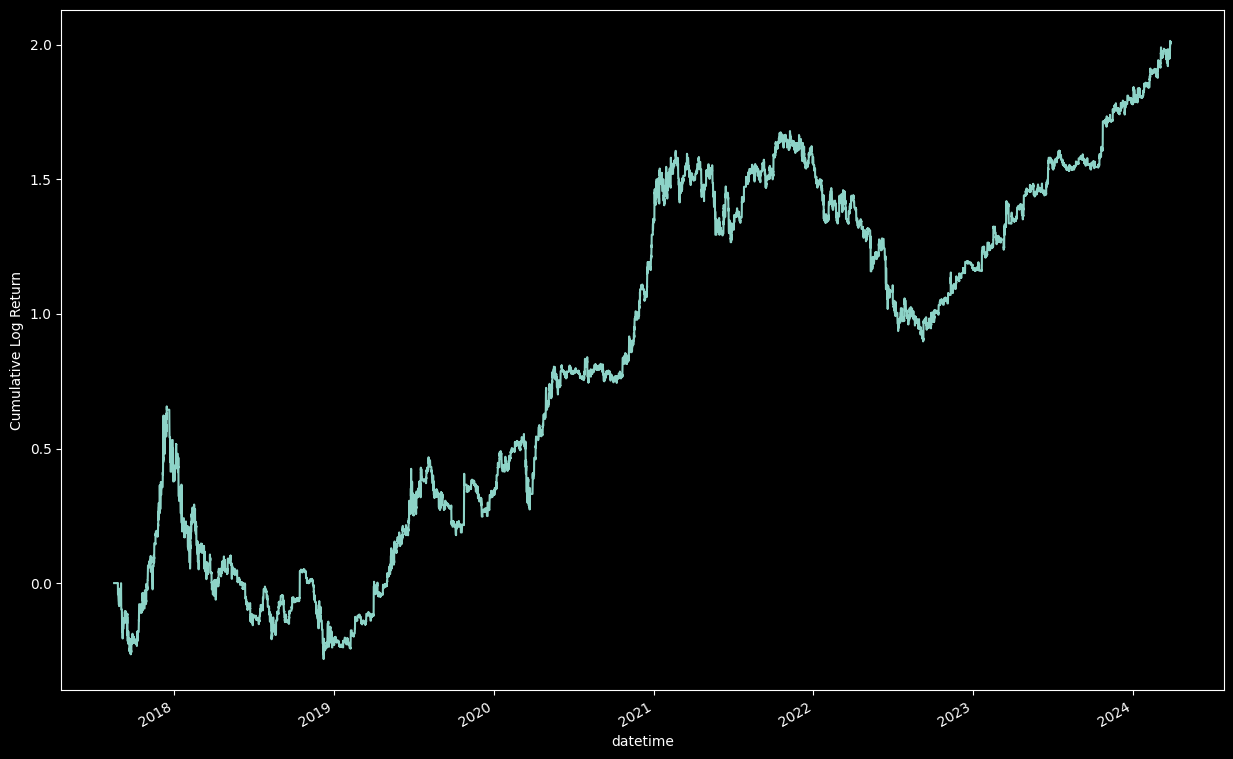

In [27]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
# from trendline_automation import fit_trendlines_single, fit_upper_trendline
import mplfinance as mpf



def trendline_breakout_dataset(
        ohlcv: pd.DataFrame, lookback: int, 
        hold_period:int=12, tp_mult: float=3.0, sl_mult: float=3.0, 
        atr_lookback: int=168
):
    assert(atr_lookback >= lookback)

    close = np.log(ohlcv['close'].to_numpy())
   
    # ATR for normalizing, setting stop loss take profit
    atr = ta.atr(np.log(ohlcv['high']), np.log(ohlcv['low']), np.log(ohlcv['close']), atr_lookback)
    atr_arr = atr.to_numpy()
   
    # Normalized volume
    return_arr = np.log(ohlcv['close'] / ohlcv['close'].shift(1))
    momentum_arr = return_arr.rolling(5).mean().to_numpy()
    volatility_arr = return_arr.rolling(20).std().to_numpy()
    distance_arr = (ohlcv['close'] - ohlcv['close'].rolling(50).mean()).to_numpy()
    # delta_arr = (ohlcv['delta'] / ohlcv['delta'].rolling(atr_lookback).median()).to_numpy() 
    aggresivness = ohlcv['bid']/ohlcv['delta'] 
    delta_arr = (aggresivness / aggresivness.rolling(lookback).mean()).to_numpy() 
    
    vol_arr = (ohlcv['volume'] / ohlcv['volume'].rolling(atr_lookback).median()).to_numpy() 
    adx = ta.adx(ohlcv['high'], ohlcv['low'], ohlcv['close'], lookback)
    adx_arr = adx['ADX_' + str(lookback)].to_numpy()

    trades = pd.DataFrame()
    trade_i = 0

    in_trade = False
    tp_price = None
    sl_price = None
    hp_i = None
    for i in range(atr_lookback, len(ohlcv)):
        # NOTE window does NOT include the current candle
        window = close[i - lookback: i]

        s_coefs, r_coefs = fit_trendlines_single(window)

        # Find current value of line
        r_val = r_coefs[1] + lookback * r_coefs[0]

        # Entry
        if not in_trade and close[i] > r_val:
            
            tp_price = close[i] + atr_arr[i] * tp_mult
            sl_price = close[i] - atr_arr[i] * sl_mult
            hp_i = i + hold_period
            in_trade = True

            trades.loc[trade_i, 'entry_i'] = i
            trades.loc[trade_i, 'entry_p'] = close[i]
            trades.loc[trade_i, 'atr'] = atr_arr[i]
            trades.loc[trade_i, 'sl'] = sl_price 
            trades.loc[trade_i, 'tp'] = tp_price 
            trades.loc[trade_i, 'hp_i'] = i + hold_period
            
            trades.loc[trade_i, 'slope'] = r_coefs[0]
            trades.loc[trade_i, 'intercept'] = r_coefs[1]


            # Trendline features
            # Resist slope
            trades.loc[trade_i, 'resist_s'] = r_coefs[0] / atr_arr[i] 
       
            # Resist erorr
            line_vals = (r_coefs[1] + np.arange(lookback) * r_coefs[0])
            err = np.sum(line_vals  - window ) / lookback
            err /= atr_arr[i]
            trades.loc[trade_i, 'tl_err'] = err

            # Max distance from resist
            diff = line_vals - window
            trades.loc[trade_i, 'max_dist'] = diff.max() / atr_arr[i]

            # Volume on breakout
            trades.loc[trade_i, 'vol'] = vol_arr[i]

            # ADX
            trades.loc[trade_i, 'adx'] = adx_arr[i]
            
            # delta breakout
            trades.loc[trade_i, 'delta'] = delta_arr[i]
            trades.loc[trade_i, 'momentum'] = momentum_arr[i]
            trades.loc[trade_i, 'volatility'] = volatility_arr[i]
            trades.loc[trade_i, 'distance'] = distance_arr[i]


        if in_trade:
            if close[i] >= tp_price or close[i] <= sl_price or i >= hp_i:
                trades.loc[trade_i, 'exit_i'] = i
                trades.loc[trade_i, 'exit_p'] = close[i]
                
                in_trade = False
                trade_i += 1

    trades['return'] = trades['exit_p'] - trades['entry_p']
    
    # Features
    # data_x = trades[['resist_s', 'tl_err', 'vol', 'max_dist', 'adx', 'delta', 'momentum', 'volatility', 'distance']]
    data_x = trades[['resist_s', 'tl_err', 'vol', 'max_dist', 'adx', 'delta']]
    # Label
    data_y = pd.Series(0, index=trades.index)
    data_y.loc[trades['return'] > 0] = 1

    return trades, data_x, data_y

if __name__ == '__main__':
    df = pd.read_csv("../../datasets/universe.csv")
    raw_data = df[df['ticker'] == 'BTCUSDT'].copy()
    # raw_data = df[df['ticker'] == 'ETHUSDT'].copy()
    # raw_data = df[df['ticker'] == 'DOGEUSDT'].copy()
    raw_data['datetime'] = pd.to_datetime(raw_data['datetime'], format="mixed")
    raw_data = raw_data.set_index('datetime')
    raw_data = raw_data.dropna()
    data = raw_data

    trades, data_x, data_y = trendline_breakout_dataset(data, 72)
    print(data_x["delta"][:100])

    # Drop any incomplete trades
    trades = trades.dropna()

    # Look at trades without any ML filter. 
    signal = np.zeros(len(data))
    for i in range(len(trades)):
        trade = trades.iloc[i]
        signal[int(trade['entry_i']):int(trade['exit_i'])] = 1.

    data['r'] = np.log(data['close']).diff().shift(-1)
    data['sig'] = signal
    returns = data['r'] * data['sig']
    
    print("Profit Factor", returns[returns > 0].sum() / returns[returns < 0].abs().sum())
    print("Win Rate", len(trades[trades['return'] > 0]) / len(trades))
    print("Average Trade", trades['return'].mean()) 


    plt.figure(figsize=(15, 10))  # You can adjust the numbers to fit your specific needs
    plt.style.use('dark_background')
    returns.cumsum().plot()
    plt.ylabel("Cumulative Log Return")


## trendline_breakout.py

57822


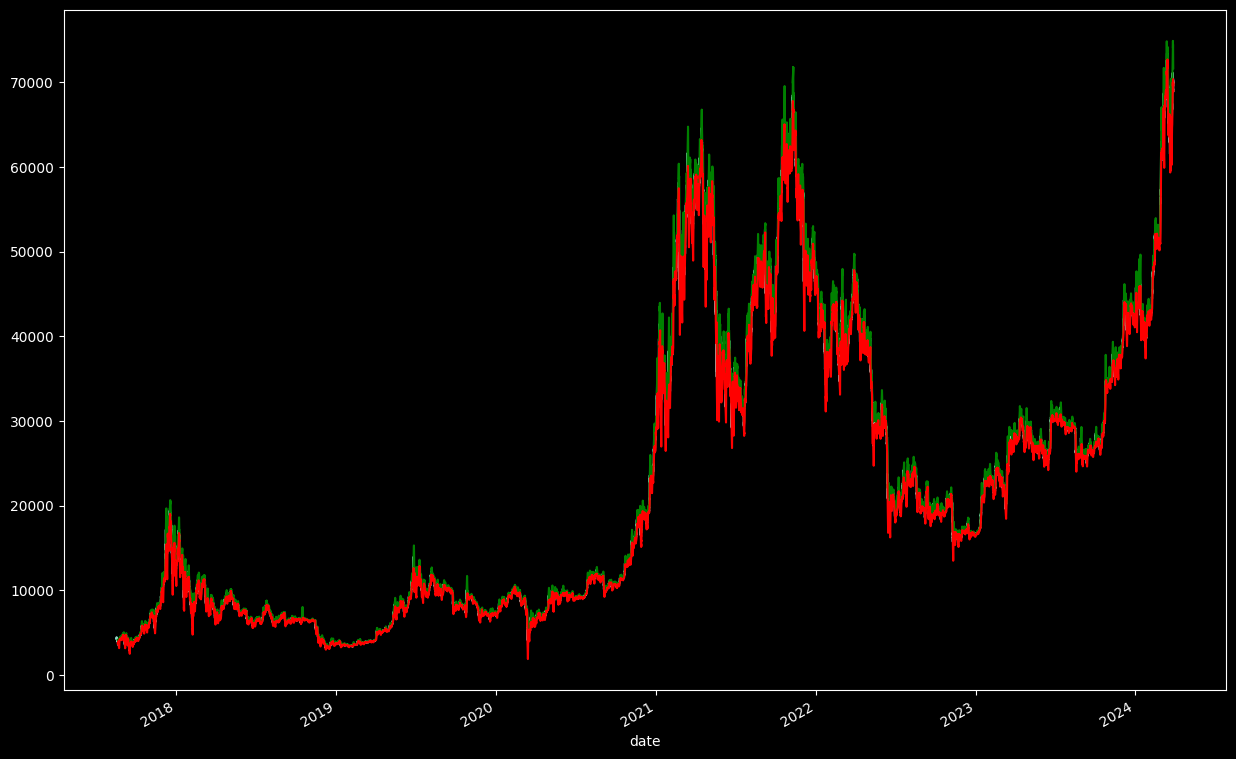

Profit Factor 72 1.034437979371513


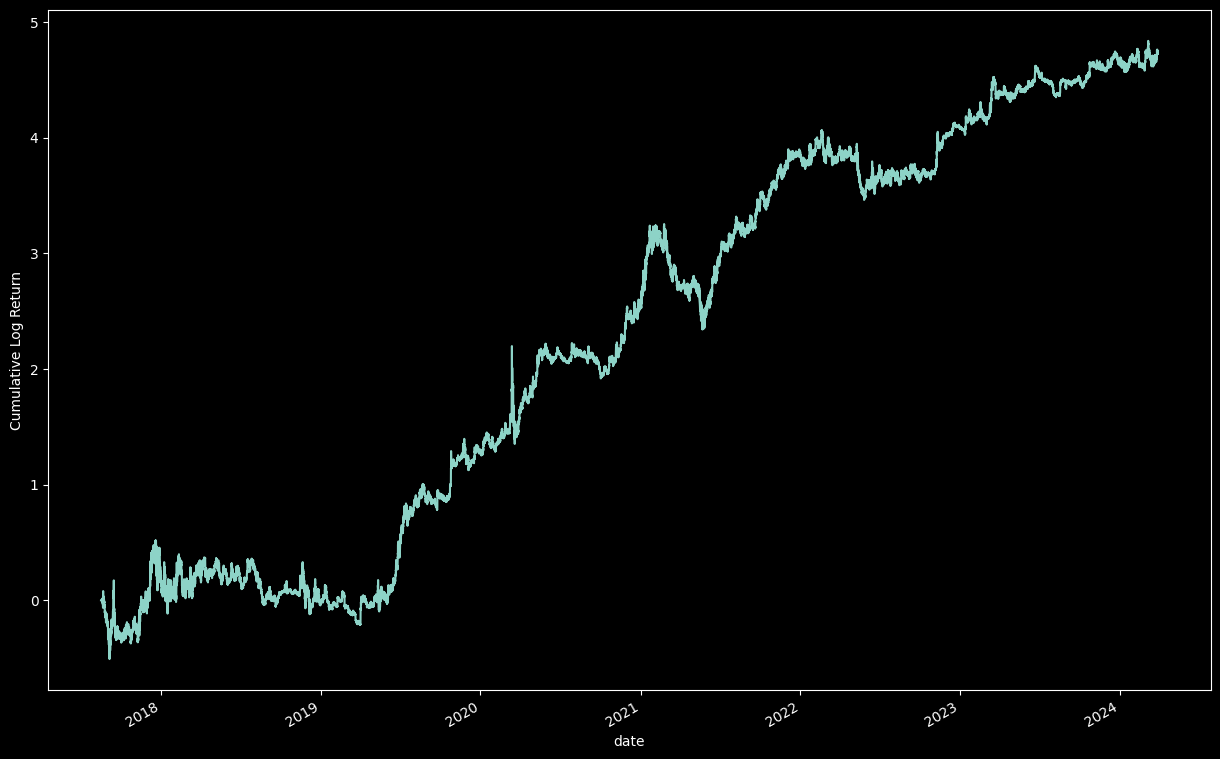

In [7]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
# from trendline_automation import fit_trendlines_single
import mplfinance as mpf

def trendline_breakout(close: np.array, lookback:int):
    s_tl = np.zeros(len(close))
    s_tl[:] = np.nan

    r_tl = np.zeros(len(close))
    r_tl[:] = np.nan

    sig = np.zeros(len(close))

    for i in range(lookback, len(close)):
        # NOTE window does NOT include the current candle
        window = close[i - lookback: i]

        s_coefs, r_coefs = fit_trendlines_single(window)

        # Find current value of line, projected forward to current bar
        s_val = s_coefs[1] + lookback * s_coefs[0] 
        r_val = r_coefs[1] + lookback * r_coefs[0] 

        s_tl[i] = s_val
        r_tl[i] = r_val

        if close[i] > r_val:
            sig[i] = 1.0
        elif close[i] < s_val:
            sig[i] = -1.0
        else:
            sig[i] = sig[i - 1]

    return s_tl, r_tl, sig


if __name__ == '__main__':
    data = pd.read_csv('btc_1h.csv')
    # data = pd.read_csv('BTCUSDT3600.csv')
    data['date'] = data['date'].astype('datetime64[s]')
    data = data.set_index('date')
    data = data.dropna()
    
    lookback = 72
    support, resist, signal = trendline_breakout(data['close'].to_numpy(), lookback)
    data['support'] = support
    data['resist'] = resist
    data['signal'] = signal

    print(len(data))
    # data = data[:2000]

    plt.figure(figsize=(15, 10))  # You can adjust the numbers to fit your specific needs
    plt.style.use('dark_background')
    data['close'].plot(label='Close')
    data['resist'].plot(label='Resistance', color='green')
    data['support'].plot(label='Support', color='red')
    plt.show()

    data['r'] = np.log(data['close']).diff().shift(-1)
    strat_r = data['signal'] * data['r']

    pf = strat_r[strat_r > 0].sum() / strat_r[strat_r < 0].abs().sum() 
    print("Profit Factor", lookback,  pf)

    plt.figure(figsize=(15, 10))  # You can adjust the numbers to fit your specific needs
    plt.style.use('dark_background')
    strat_r.cumsum().plot()
    plt.ylabel("Cumulative Log Return")
    plt.show()
    
    '''
    lookbacks = list(range(24, 169, 2))
    pfs = []

    lookback_returns = pd.DataFrame()
    for lookback in lookbacks:
        support, resist, signal = trendline_breakout(data['close'].to_numpy(), lookback)
        data['signal'] = signal

        data['r'] = np.log(data['close']).diff().shift(-1)
        strat_r = data['signal'] * data['r']

        pf = strat_r[strat_r > 0].sum() / strat_r[strat_r < 0].abs().sum() 
        print("Profit Factor", lookback,  pf)
        pfs.append(pf)

        lookback_returns[lookback] = strat_r

    plt.style.use('dark_background')
    x = pd.Series(pfs, index=lookbacks)
    x.plot()
    plt.ylabel("Profit Factor")
    plt.xlabel("Trendline Lookback")
    plt.axhline(1.0, color='white')

    '''


## trendline_automation.py

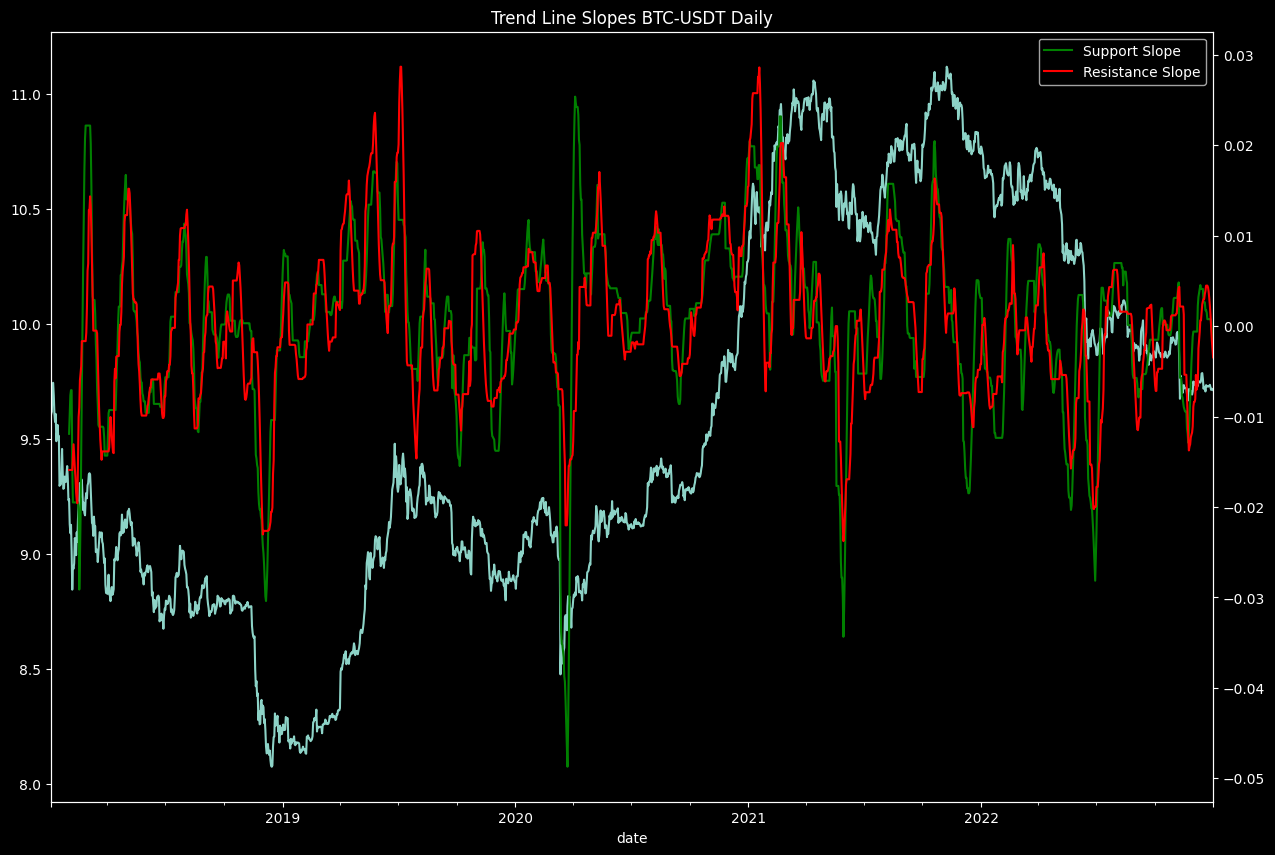

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def check_trend_line(support: bool, pivot: int, slope: float, y: np.array):
    # compute sum of differences between line and prices, 
    # return negative val if invalid 
    
    # Find the intercept of the line going through pivot point with given slope
    intercept = -slope * pivot + y[pivot]
    line_vals = slope * np.arange(len(y)) + intercept
     
    diffs = line_vals - y
    
    # Check to see if the line is valid, return -1 if it is not valid.
    if support and diffs.max() > 1e-5:
        return -1.0
    elif not support and diffs.min() < -1e-5:
        return -1.0

    # Squared sum of diffs between data and line 
    err = (diffs ** 2.0).sum()
    return err;


def optimize_slope(support: bool, pivot:int , init_slope: float, y: np.array):
    
    # Amount to change slope by. Multiplyed by opt_step
    slope_unit = (y.max() - y.min()) / len(y) 
    
    # Optmization variables
    opt_step = 1.0
    min_step = 0.0001
    curr_step = opt_step # current step
    
    # Initiate at the slope of the line of best fit
    best_slope = init_slope
    best_err = check_trend_line(support, pivot, init_slope, y)
    assert(best_err >= 0.0) # Shouldn't ever fail with initial slope

    get_derivative = True
    derivative = None
    while curr_step > min_step:

        if get_derivative:
            # Numerical differentiation, increase slope by very small amount
            # to see if error increases/decreases. 
            # Gives us the direction to change slope.
            slope_change = best_slope + slope_unit * min_step
            test_err = check_trend_line(support, pivot, slope_change, y)
            derivative = test_err - best_err;
            
            # If increasing by a small amount fails, 
            # try decreasing by a small amount
            if test_err < 0.0:
                slope_change = best_slope - slope_unit * min_step
                test_err = check_trend_line(support, pivot, slope_change, y)
                derivative = best_err - test_err

            if test_err < 0.0: # Derivative failed, give up
                raise Exception("Derivative failed. Check your data. ")

            get_derivative = False

        if derivative > 0.0: # Increasing slope increased error
            test_slope = best_slope - slope_unit * curr_step
        else: # Increasing slope decreased error
            test_slope = best_slope + slope_unit * curr_step
        

        test_err = check_trend_line(support, pivot, test_slope, y)
        if test_err < 0 or test_err >= best_err: 
            # slope failed/didn't reduce error
            curr_step *= 0.5 # Reduce step size
        else: # test slope reduced error
            best_err = test_err 
            best_slope = test_slope
            get_derivative = True # Recompute derivative
    
    # Optimize done, return best slope and intercept
    return (best_slope, -best_slope * pivot + y[pivot])


def fit_upper_trendline(data: np.array):
    x = np.arange(len(data))
    coefs = np.polyfit(x, data, 1)
    line_points = coefs[0] * x + coefs[1]
    upper_pivot = (data - line_points).argmax() 
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], data)
    return resist_coefs 

def fit_lower_trendline(data: np.array):
    x = np.arange(len(data))
    coefs = np.polyfit(x, data, 1)
    line_points = coefs[0] * x + coefs[1]
    lower_pivot = (data - line_points).argmin() 
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], data)
    return support_coefs 

def fit_trendlines_single(data: np.array):
    # find line of best fit (least squared) 
    # coefs[0] = slope,  coefs[1] = intercept 
    x = np.arange(len(data))
    coefs = np.polyfit(x, data, 1)

    # Get points of line.
    line_points = coefs[0] * x + coefs[1]

    # Find upper and lower pivot points
    upper_pivot = (data - line_points).argmax() 
    lower_pivot = (data - line_points).argmin() 
   
    # Optimize the slope for both trend lines
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], data)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], data)

    return (support_coefs, resist_coefs) 



def fit_trendlines_high_low(high: np.array, low: np.array, close: np.array):
    x = np.arange(len(close))
    coefs = np.polyfit(x, close, 1)
    # coefs[0] = slope,  coefs[1] = intercept
    line_points = coefs[0] * x + coefs[1]
    upper_pivot = (high - line_points).argmax() 
    lower_pivot = (low - line_points).argmin() 
    
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], low)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], high)

    return (support_coefs, resist_coefs)


if __name__ == '__main__':

    # Load data
    data = pd.read_csv('BTCUSDT86400.csv')
    data['date'] = data['date'].astype('datetime64[s]')
    data = data.set_index('date')

    # Take natural log of data to resolve price scaling issues
    data = np.log(data)
    # Trendline parameter
    lookback = 30


    support_slope = [np.nan] * len(data)
    resist_slope = [np.nan] * len(data)
    for i in range(lookback - 1, len(data)):
        candles = data.iloc[i - lookback + 1: i + 1]
        support_coefs, resist_coefs =  fit_trendlines_high_low(candles['high'], 
                                                               candles['low'], 
                                                               candles['close'])
        support_slope[i] = support_coefs[0]
        resist_slope[i] = resist_coefs[0]

    data['support_slope'] = support_slope
    data['resist_slope'] = resist_slope

    plt.style.use('dark_background')
    fig, ax1 = plt.subplots(figsize=(15, 10))
    ax2 = ax1.twinx()
    data['close'].plot(ax=ax1)
    data['support_slope'].plot(ax=ax2, label='Support Slope', color='green')
    data['resist_slope'].plot(ax=ax2, label='Resistance Slope', color='red')
    plt.title("Trend Line Slopes BTC-USDT Daily")
    plt.legend()
    plt.show()

